## 1 - Cargar bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 2 - Obtener datos

In [2]:
ruta = "./src/data_sample/ventas/"

archivos = [f for f in os.listdir(ruta) if f.endswith('.csv')]
print(archivos)

dfs = {}
for fichero in archivos:
    dfs[fichero] = pd.read_csv(ruta + fichero)

df = pd.concat(dfs.values(), ignore_index=True)
print(f'Total filas cargadas: {len(df)}')
df.head()

['v_abril_2025.csv', 'v_agosto_2025.csv', 'v_diciembre_2025.csv', 'v_enero_2025.csv', 'v_febrero_2025.csv', 'v_julio_2025.csv', 'v_junio_2025.csv', 'v_marzo_2025.csv', 'v_mayo_2025.csv', 'v_noviembre_2025.csv', 'v_octubre_2025.csv', 'v_septiembre_2025.csv']
Total filas cargadas: 24000


,Fuente,Referencia,Operación,Tipología,Título,C.P.,Municipio,Provincia,Distrito,Barrio,...,Descartado,Estado,Ranking,Dormitorios,Baños,Superficie,Precio,Precio unitario,Días,Demanda
0,Fotocasa,0292687,Venta,Plurifamiliar,Piso en Venta en Arrancapins,46007.0,Valencia,Valencia,Extramurs,Arrancapins,...,No,No contactado,9421,4.0,2.0,129,530000,4108,1,Muy baja
1,habitaclia,2629,Venta,Plurifamiliar,Vive la Valencia más auténtica en esta joya e...,NaN,Valencia,Valencia,La Saïdia,Sant Antoni,...,No,No contactado,4728,1.0,1.0,78,250000,3205,1,Muy baja
2,milanuncios,542365647,Venta,Plurifamiliar,Valencia Capital,46009.0,Valencia,Valencia,La Saïdia,Sant Antoni,...,No,No contactado,3671,1.0,1.0,78,250000,3205,1,Muy baja
3,Fotocasa,25VIV06586,Venta,Plurifamiliar,"Piso en Venta en PADRE PEDRO VELASCO, 5, La M...",46011.0,Valencia,Valencia,Poblats Marítims,La Malva-rosa,...,No,No contactado,280,3.0,1.0,64,58500,914,1,Alta
4,habitaclia,25VIV06586,Venta,Plurifamiliar,NaN,NaN,Valencia,Valencia,Poblats Marítims,La Malva-rosa,...,No,No contactado,10154,3.0,1.0,64,58500,914,1,Muy baja


## 3 - Separar Train y Test
> **Importante:** el split se hace ANTES de cualquier limpieza o transformación para evitar data leakage.

In [3]:
# Creamos referencia interna para poder eliminar duplicados
df['Referencia_interna'] = df['Latitud'].astype(str) + df['Longitud'].astype(str)

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
print(f'Train: {len(train_set)} filas')
print(f'Test:  {len(test_set)} filas')

Train: 19200 filas
Test:  4800 filas


## 4 - EDA (sobre train únicamente)

In [4]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19200 entries, 3572 to 23654
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fuente              19200 non-null  object 
 1   Referencia          18738 non-null  object 
 2   Operación           19200 non-null  object 
 3   Tipología           19200 non-null  object 
 4   Título              17594 non-null  object 
 5   C.P.                12743 non-null  float64
 6   Municipio           19200 non-null  object 
 7   Provincia           19200 non-null  object 
 8   Distrito            19200 non-null  object 
 9   Barrio              17611 non-null  object 
 10  Latitud             19200 non-null  float64
 11  Longitud            19200 non-null  float64
 12  Planta              16162 non-null  object 
 13  Anunciante          19200 non-null  object 
 14  Empresa             18874 non-null  object 
 15  Aire acondicionado  19200 non-null  object 
 16  Ascens

In [5]:
# Eliminar duplicados
# CORRECCION: era df.drop_duplicates -> debe ser train_set.drop_duplicates
train_set = train_set.sort_values(by='Precio')
train_set = train_set.drop_duplicates(subset=['Referencia_interna'])
print(f'Tras eliminar duplicados: {len(train_set)} filas')

Tras eliminar duplicados: 15724 filas


In [6]:
# Columnas a eliminar
columnas_a_eliminar = [
    'Tipologia', 'Titulo', 'Provincia', 'Municipio', 'C.P.',
    'Planta', 'Empresa', 'Imagen', 'URL', 'Telefono',
    'Email', 'Posible agencia', 'Referencia', 'Operacion', 'Fecha de creacion',
    'Comentarios', 'Descartado', 'Estado', 'Ranking', 'Dias', 'Conservacion'
]
train_set = train_set.drop(columns=columnas_a_eliminar, errors='ignore')
print(f'Columnas restantes: {len(train_set.columns)}')
train_set.head()

Columnas restantes: 28


,Fuente,Operación,Tipología,Título,Distrito,Barrio,Latitud,Longitud,Anunciante,Aire acondicionado,...,Teléfono,Conservación,Dormitorios,Baños,Superficie,Precio,Precio unitario,Días,Demanda,Referencia_interna
16069,habitaclia,Venta,Plurifamiliar,Disfruta todo el año de la playa viviendo en V...,Poblats Marítims,El Cabanyal - El Canyamelar,39.470425,-0.326111,Particular,Sí,...,654384241,Muy bueno,1.0,1.0,43,1000,23,4,Muy baja,39.4704248-0.3261109
18583,habitaclia,Venta,Plurifamiliar,Viviendas en alquiler en Castellar Oliveral,El Castellar i l'Oliverar,NaN,39.432076,-0.361421,Profesional,Sí,...,615246793,Muy bueno,3.0,2.0,80,1000,12,3,Muy baja,39.4320755897-0.3614214451
9846,habitaclia,Venta,Plurifamiliar,"Piso de 47 m2 en venta en La Petxina, València",Extramurs,La Petxina,39.471585,-0.388141,Profesional,Sí,...,658016805,Muy bueno,2.0,1.0,47,1090,23,1,Muy baja,39.4715848115-0.3881411885
22737,habitaclia,Venta,Plurifamiliar,PISO CON PLAZA DE APARCAMIENTO EN ALQUILER EN ...,Ciutat Vella,El Pilar,39.471778,-0.382368,Profesional,No,...,695674672,Muy bueno,2.0,1.0,82,1200,14,1,Muy baja,39.4717781113-0.3823677887
14660,habitaclia,Venta,Plurifamiliar,"Se necesita ,al menos, ingresos de 3800 netos ...",Camins al Grau,La Creu del Grau,39.460108,-0.340374,Profesional,Sí,...,963759165,Muy bueno,1.0,1.0,54,1250,23,3,Muy baja,39.4601084772-0.3403738771


In [7]:
# Nulos
nulos = train_set.isnull().sum()
porcentaje = (nulos / len(train_set)) * 100
resumen = pd.DataFrame({'Nulos': nulos, 'Porcentaje': porcentaje})
print(resumen[resumen['Nulos'] > 0].sort_values('Porcentaje', ascending=False))

              Nulos  Porcentaje
Conservación   6352   40.396846
Barrio         1287    8.184940
Título         1186    7.542610
Dormitorios     625    3.974816
Baños           617    3.923938
Teléfono        258    1.640804


In [8]:
train_set = train_set.dropna(subset=['Barrio', 'Baños', 'Dormitorios'])
print(f'Filas restantes: {len(train_set)}')

Filas restantes: 13752


In [9]:
# CORRECCION: filtrar outliers de Precio unitario
# Rango razonable para Valencia: 500 - 15000 euros/m2
print('Antes del filtro:')
print(train_set['Precio unitario'].describe())

train_set = train_set[
    (train_set['Precio unitario'] >= 500) &
    (train_set['Precio unitario'] <= 15000)
]
print(f'\nTras filtrar outliers de precio: {len(train_set)} filas')
print(train_set['Precio unitario'].describe())

Antes del filtro:
count     13752.000000
mean       3156.228258
std        8104.968231
min     -720000.000000
25%        2439.000000
50%        3081.000000
75%        3908.250000
max       19500.000000
Name: Precio unitario, dtype: float64

Tras filtrar outliers de precio: 13669 filas
count    13669.000000
mean      3304.954642
std       1348.169735
min        500.000000
25%       2450.000000
50%       3088.000000
75%       3910.000000
max      12078.000000
Name: Precio unitario, dtype: float64


### Análisis univariante

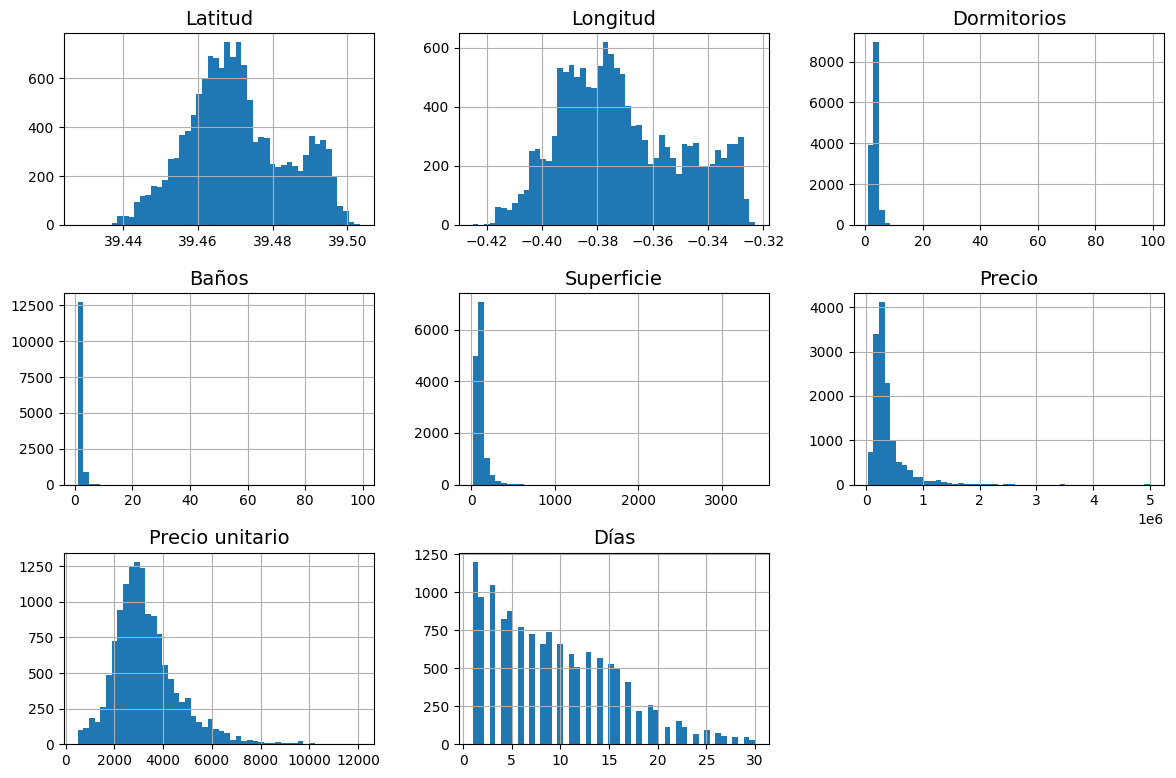

In [10]:
train_set.hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

### Análisis bivariante / multivariante

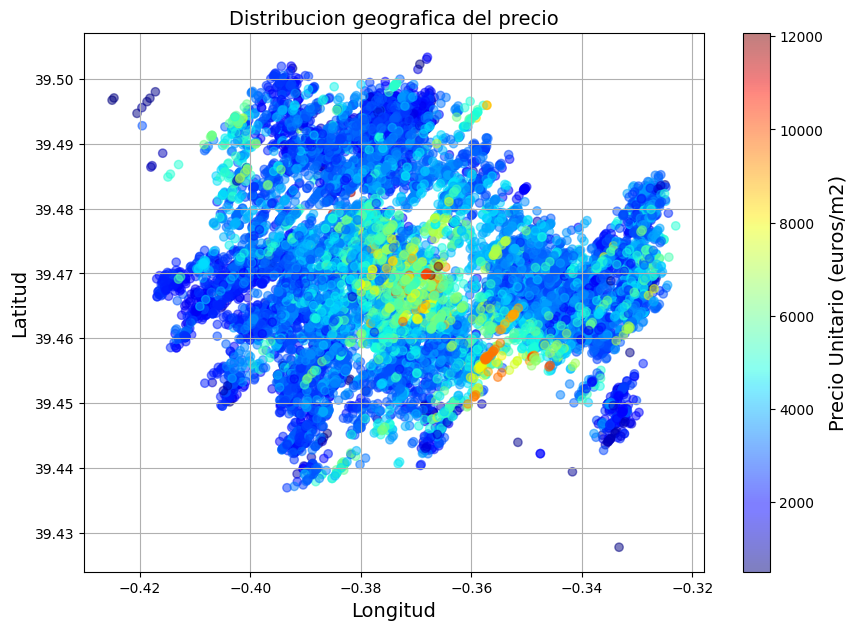

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(train_set['Longitud'], train_set['Latitud'],
            c=train_set['Precio unitario'], cmap='jet', alpha=0.5)
plt.grid()
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar(label='Precio Unitario (euros/m2)')
plt.title('Distribucion geografica del precio')
plt.show()

In [12]:
# Correlacion con el target
corr_matrix = train_set.corr(numeric_only=True)
corr_matrix['Precio unitario'].sort_values(ascending=False)

Precio unitario    1.000000
Precio             0.632280
Baños              0.171351
Longitud           0.096102
Superficie         0.091481
Días               0.064904
Dormitorios       -0.074330
Latitud           -0.101511
Name: Precio unitario, dtype: float64

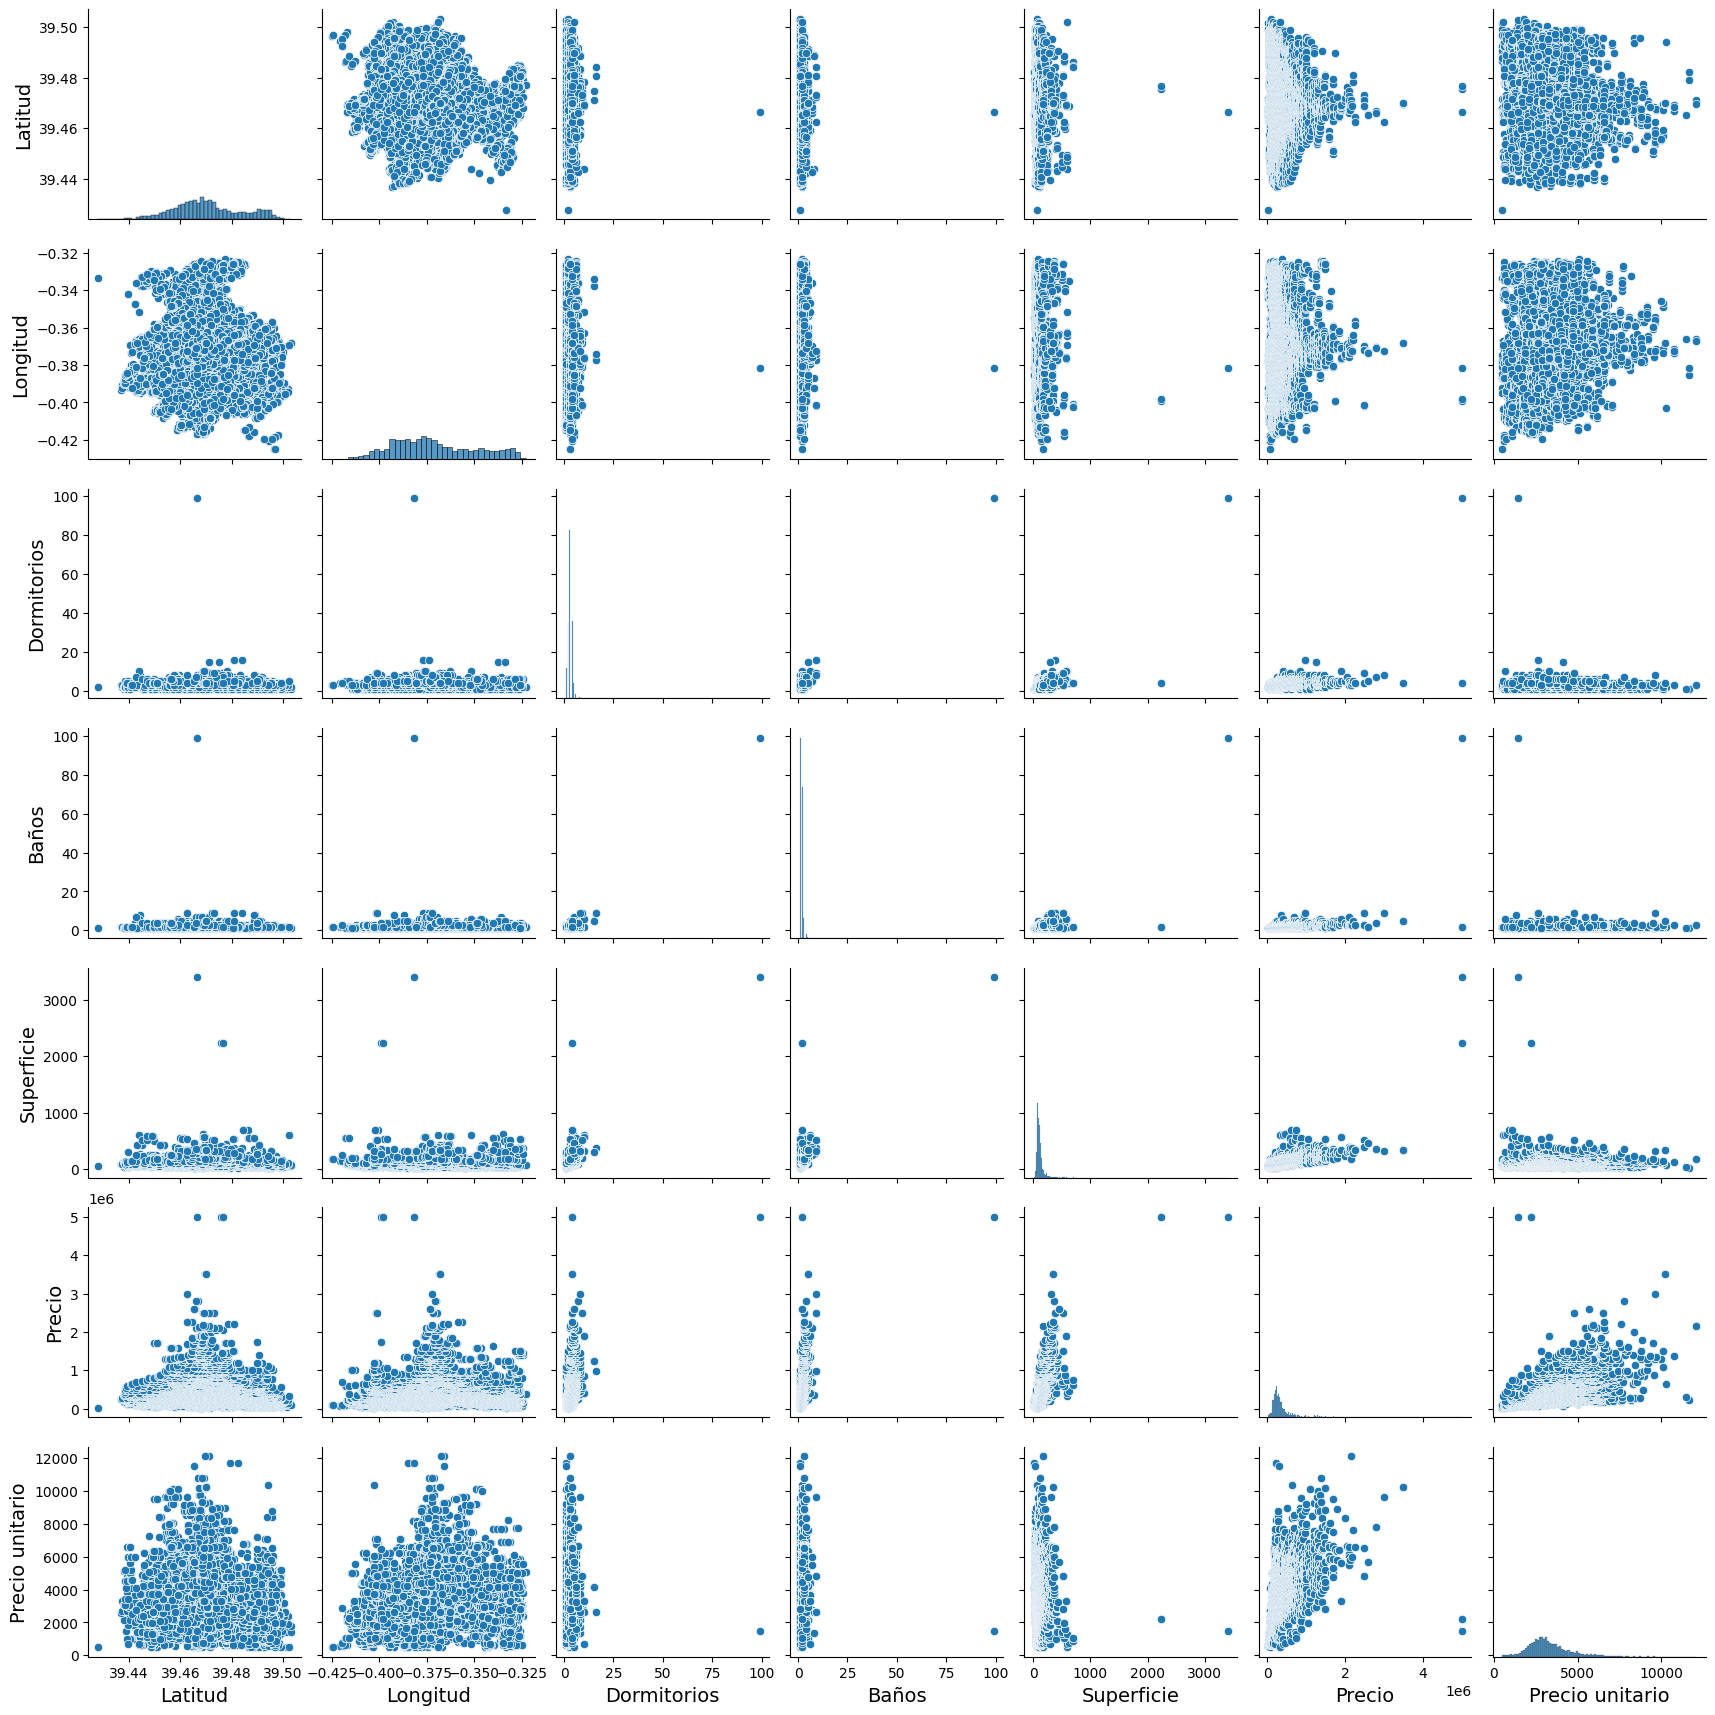

In [13]:
columnas = corr_matrix['Precio unitario'][
    corr_matrix['Precio unitario'].abs() > 0.07
].index.to_list()
sns.pairplot(train_set[columnas])
plt.show()

## 5 - Tratamiento de features categóricas

In [14]:
train_set_bck = train_set.copy()

cat_cols = ['Fuente', 'Distrito', 'Barrio', 'Anunciante', 'Aire acondicionado',
            'Ascensor', 'Garaje', 'Trastero', 'Terraza', 'Piscina',
            'Zonas verdes', 'Zona deportiva', 'Demanda']

train_set = pd.get_dummies(train_set, columns=cat_cols, dtype=int)
print(f'Columnas tras OHE: {len(train_set.columns)}')

Columnas tras OHE: 129


## 6 - Tratamiento de features numéricas (escalar)
> **CORRECCIÓN:** El scaler se ajusta solo con el train y se aplica también al train_set. Precio unitario (target) NO se escala.

In [15]:
features_num = ['Latitud', 'Longitud', 'Dormitorios', 'Baños', 'Superficie']

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

# fit_transform solo en train
train_set[features_num] = min_max_scaler.fit_transform(train_set[features_num])

print('Scaler aplicado al train_set')
train_set[features_num].describe()

Scaler aplicado al train_set


,Latitud,Longitud,Dormitorios,Baños,Superficie
count,13669.000000,13669.000000,13669.000000,13669.000000,13669.000000
mean,0.133385,0.057316,-0.959164,-0.988365,-0.946143
std,0.351861,0.427708,0.028032,0.022412,0.039237
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.107219,-0.271224,-0.979592,-1.000000,-0.965120
50%,0.093216,-0.013475,-0.959184,-1.000000,-0.953887
75%,0.363554,0.377370,-0.938776,-0.979592,-0.939107
max,1.000000,1.000000,1.000000,1.000000,1.000000


## 7 - Modelado

In [16]:
target = 'Precio unitario'

cols_ohe = [c for c in train_set.columns if any(
    c.startswith(p) for p in ['Fuente_', 'Distrito_', 'Barrio_', 'Anunciante_',
    'Aire acondicionado_', 'Ascensor_', 'Garaje_', 'Trastero_',
    'Terraza_', 'Piscina_', 'Zonas verdes_', 'Zona deportiva_', 'Demanda_']
)]

features = features_num + cols_ohe
print(f'Total features: {len(features)}')

X = train_set[features].copy()
y = train_set[target]

Total features: 119


In [17]:
# Regresion Lineal
lin_reg = LinearRegression()

# Arbol con max_depth y min_samples_leaf para evitar overfitting
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_leaf=10)

# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

lin_reg.fit(X, y)
tree_reg.fit(X, y)
rf_reg.fit(X, y)
print('Modelos entrenados')

Modelos entrenados


## 8 - Evaluación con Cross-Validation (sobre train)

In [18]:
lin_rmses  = -cross_val_score(lin_reg,  X, y, scoring='neg_root_mean_squared_error', cv=10)
tree_rmses = -cross_val_score(tree_reg, X, y, scoring='neg_root_mean_squared_error', cv=10)
rf_rmses   = -cross_val_score(rf_reg,   X, y, scoring='neg_root_mean_squared_error', cv=10)

print('Cross-Validation (10 folds) - RMSE en euros/m2')
print('Regresion Lineal:')
print(pd.Series(lin_rmses).describe().round(0))
print('\nArbol de Decision:')
print(pd.Series(tree_rmses).describe().round(0))
print('\nRandom Forest:')
print(pd.Series(rf_rmses).describe().round(0))

Cross-Validation (10 folds) - RMSE en euros/m2
Regresion Lineal:
count      10.0
mean     1032.0
std       572.0
min       723.0
25%       745.0
50%       772.0
75%      1034.0
max      2566.0
dtype: float64

Arbol de Decision:
count      10.0
mean     1185.0
std       574.0
min       769.0
25%       839.0
50%       881.0
75%      1433.0
max      2556.0
dtype: float64

Random Forest:
count      10.0
mean     1099.0
std       572.0
min       708.0
25%       744.0
50%       797.0
75%      1290.0
max      2491.0
dtype: float64


## 9 - Evaluación contra el Test Set

In [19]:
# Preprocesar test igual que train
columnas_a_eliminar = [
    'Tipologia', 'Titulo', 'Provincia', 'Municipio', 'C.P.',
    'Planta', 'Empresa', 'Imagen', 'URL', 'Telefono',
    'Email', 'Posible agencia', 'Referencia', 'Operacion', 'Fecha de creacion',
    'Comentarios', 'Descartado', 'Estado', 'Ranking', 'Dias', 'Conservacion'
]
test_set = test_set.drop(columns=columnas_a_eliminar, errors='ignore')
test_set = test_set.dropna(subset=['Barrio', 'Baños', 'Dormitorios'])

# Mismo filtro de outliers que en train
test_set = test_set[
    (test_set['Precio unitario'] >= 500) &
    (test_set['Precio unitario'] <= 15000)
]

# One-hot encoding
test_set = pd.get_dummies(test_set, columns=cat_cols, dtype=int)

# Alinear columnas con train (barrios nuevos -> 0)
X_test = test_set.reindex(columns=features, fill_value=0)
y_test = test_set[target]

# Escalar con el scaler ya ajustado en train (sin re-fit)
X_test[features_num] = min_max_scaler.transform(X_test[features_num])

print(f'Test listo: {X_test.shape[0]} filas, {X_test.shape[1]} features')

Test listo: 4142 filas, 119 features


In [20]:
test_pred_lin  = lin_reg.predict(X_test)
test_pred_tree = tree_reg.predict(X_test)
test_pred_rf   = rf_reg.predict(X_test)

def evaluar_modelo(nombre, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    sep  = '=' * 45
    print(sep)
    print('  ' + nombre)
    print(sep)
    print('  RMSE : ' + str(round(rmse)) + ' euros/m2')
    print('  MAE  : ' + str(round(mae))  + ' euros/m2')
    print('  R2   : ' + str(round(r2, 3)))

evaluar_modelo('Regresion Lineal  - TEST', y_test, test_pred_lin)
evaluar_modelo('Arbol de Decision - TEST', y_test, test_pred_tree)
evaluar_modelo('Random Forest     - TEST', y_test, test_pred_rf)

  Regresion Lineal  - TEST
  RMSE : 1006 euros/m2
  MAE  : 676 euros/m2
  R2   : 0.5
  Arbol de Decision - TEST
  RMSE : 1036 euros/m2
  MAE  : 704 euros/m2
  R2   : 0.469
  Random Forest     - TEST
  RMSE : 723 euros/m2
  MAE  : 393 euros/m2
  R2   : 0.741


In [21]:
# Comparativa Train vs Test
rmse_lin_train  = np.sqrt(mean_squared_error(y, lin_reg.predict(X)))
rmse_tree_train = np.sqrt(mean_squared_error(y, tree_reg.predict(X)))
rmse_rf_train   = np.sqrt(mean_squared_error(y, rf_reg.predict(X)))
rmse_lin_test   = np.sqrt(mean_squared_error(y_test, test_pred_lin))
rmse_tree_test  = np.sqrt(mean_squared_error(y_test, test_pred_tree))
rmse_rf_test    = np.sqrt(mean_squared_error(y_test, test_pred_rf))

print('Comparativa Train vs Test (RMSE en euros/m2)')
print('Modelo                    Train       Test    Diferencia')
print('-' * 60)
print('Regresion Lineal     ' + str(round(rmse_lin_train)).rjust(8) +
      str(round(rmse_lin_test)).rjust(10) +
      ('+' + str(round(rmse_lin_test - rmse_lin_train))).rjust(12))
print('Arbol de Decision    ' + str(round(rmse_tree_train)).rjust(8) +
      str(round(rmse_tree_test)).rjust(10) +
      ('+' + str(round(rmse_tree_test - rmse_tree_train))).rjust(12))
print('Random Forest        ' + str(round(rmse_rf_train)).rjust(8) +
      str(round(rmse_rf_test)).rjust(10) +
      ('+' + str(round(rmse_rf_test - rmse_rf_train))).rjust(12))

Comparativa Train vs Test (RMSE en euros/m2)
Modelo                    Train       Test    Diferencia
------------------------------------------------------------
Regresion Lineal          920      1006         +86
Arbol de Decision         866      1036        +170
Random Forest             247       723        +477


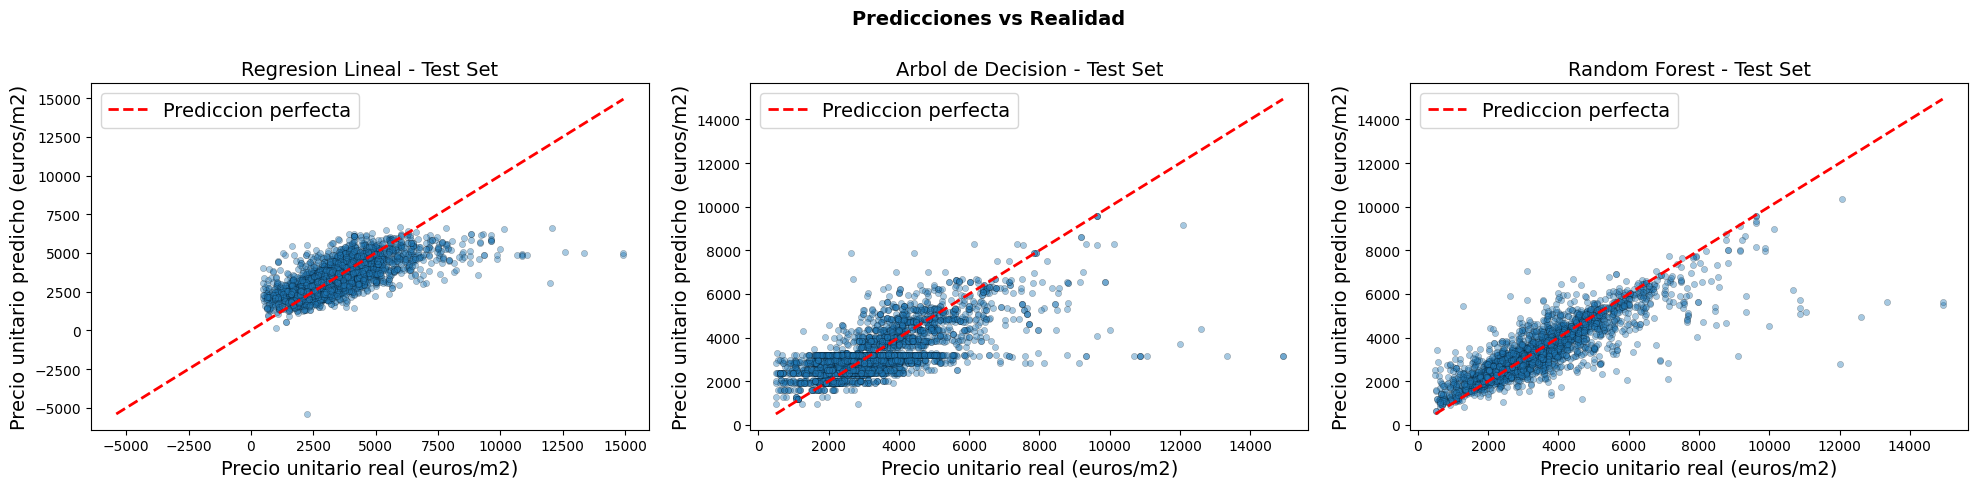

In [22]:
# Grafico: Predicciones vs Realidad
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

modelos = [
    (test_pred_lin,  'Regresion Lineal'),
    (test_pred_tree, 'Arbol de Decision'),
    (test_pred_rf,   'Random Forest')
]
for ax, (preds, nombre) in zip(axes, modelos):
    ax.scatter(y_test, preds, alpha=0.4, edgecolors='k', linewidths=0.3, s=20)
    lims = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
    ax.plot(lims, lims, 'r--', linewidth=2, label='Prediccion perfecta')
    ax.set_xlabel('Precio unitario real (euros/m2)')
    ax.set_ylabel('Precio unitario predicho (euros/m2)')
    ax.set_title(nombre + ' - Test Set')
    ax.legend()

plt.suptitle('Predicciones vs Realidad', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Importancia de features (Random Forest)

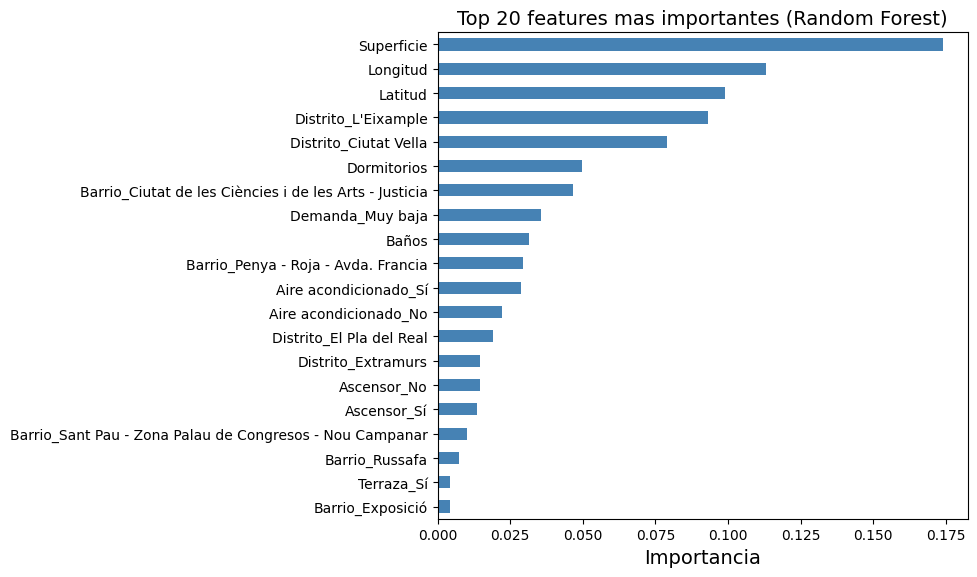

In [23]:
# Random Forest nos da la importancia de cada feature
importancias = pd.Series(rf_reg.feature_importances_, index=features)
top20 = importancias.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
top20.sort_values().plot(kind='barh', color='steelblue')
plt.xlabel('Importancia')
plt.title('Top 20 features mas importantes (Random Forest)')
plt.tight_layout()
plt.show()

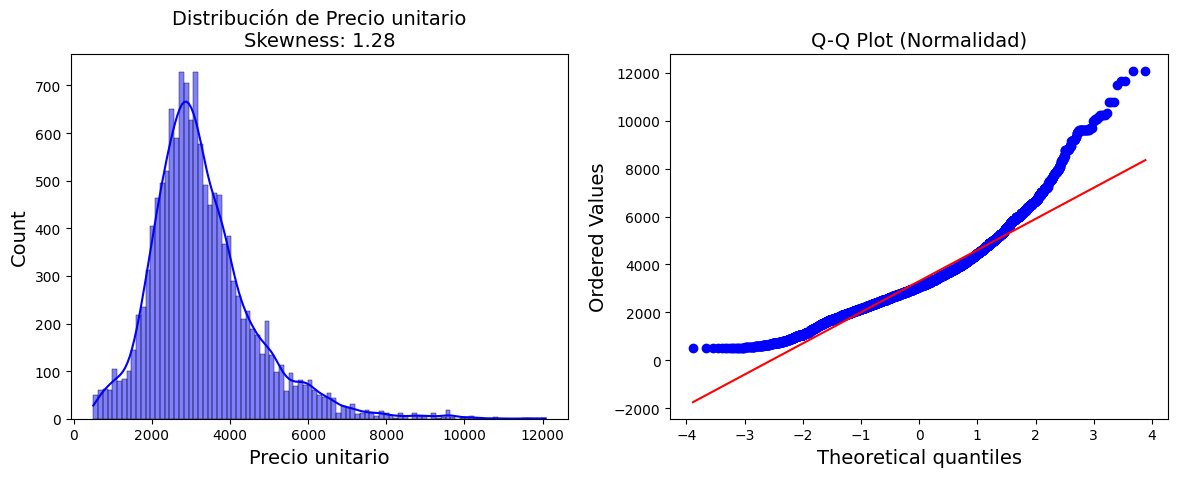

In [24]:
import scipy.stats as stats

def plot_target_distribution(df, target_col):
    plt.figure(figsize=(12, 5))
    
    # Histograma con curva de densidad
    plt.subplot(1, 2, 1)
    sns.histplot(df[target_col], kde=True, color='blue')
    plt.title(f'Distribución de {target_col}\nSkewness: {df[target_col].skew():.2f}')
    
    # Q-Q Plot para ver si es normal
    plt.subplot(1, 2, 2)
    stats.probplot(df[target_col], plot=plt)
    plt.title('Q-Q Plot (Normalidad)')
    
    plt.tight_layout()
    plt.show()

# Prueba con el nombre exacto de tu DataFrame original
plot_target_distribution(train_set, 'Precio unitario')

C:\Users\33778\AppData\Local\Temp\ipykernel_5888\1112008495.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y=target, data=df, palette='viridis')
C:\Users\33778\AppData\Local\Temp\ipykernel_5888\1112008495.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y=target, data=df, palette='viridis')
C:\Users\33778\AppData\Local\Temp\ipykernel_5888\1112008495.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y=target, data=df, palette='viridis')
C:\Users\33778\AppData\Local\Temp\ipykernel_5888\1112008495.py:8: FutureWarn

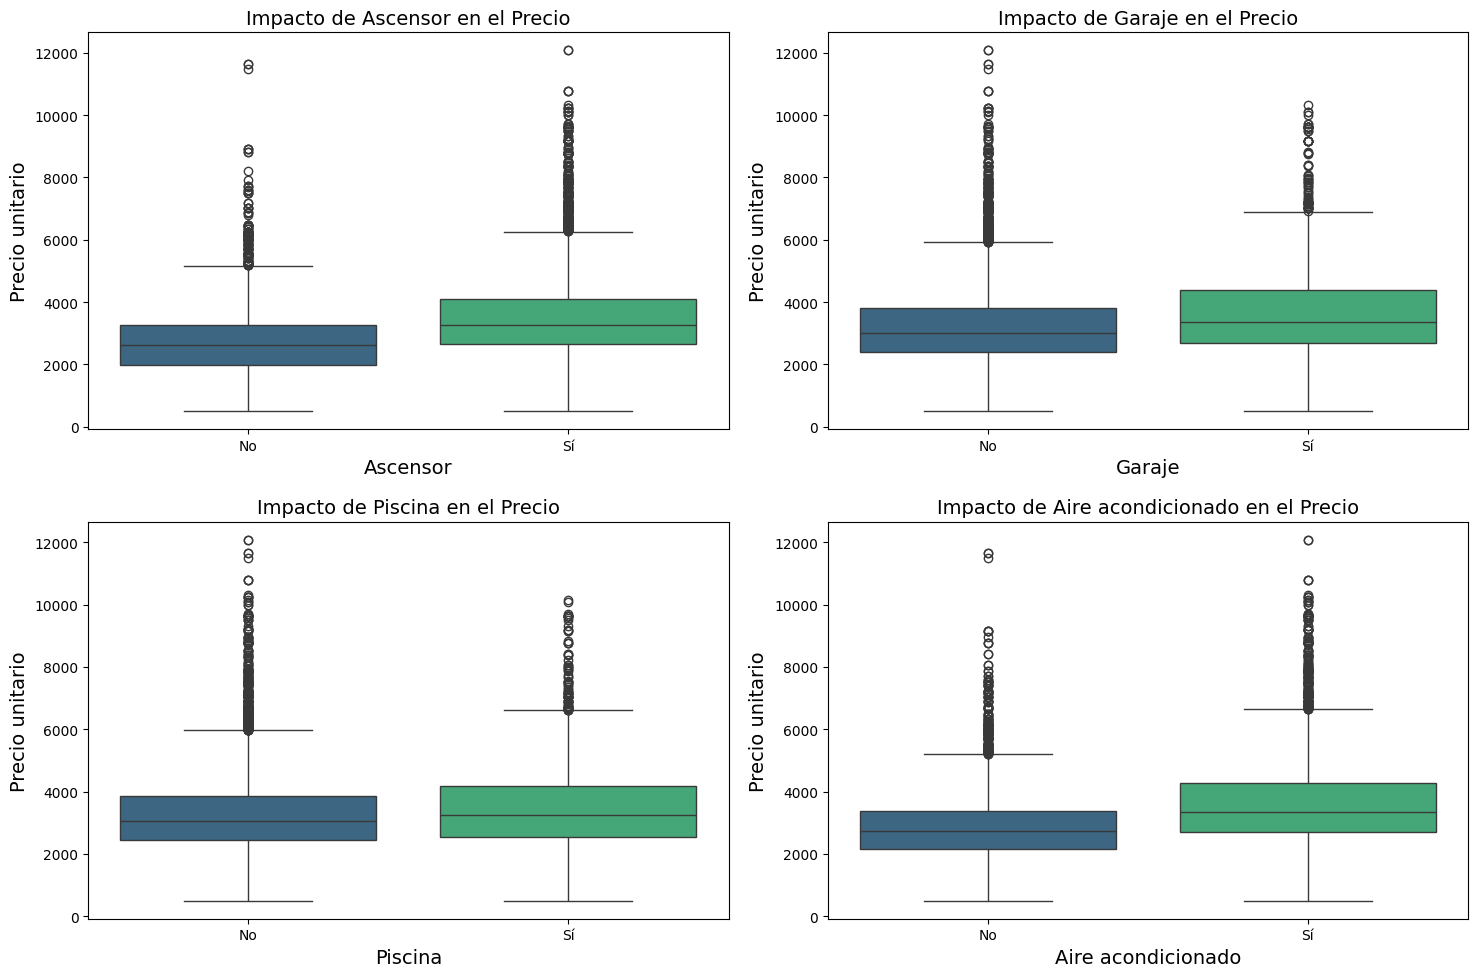

In [27]:
def plot_categorical_impact(df, cat_cols, target):
    # Elegimos algunas columnas clave para no saturar
    cols_to_plot = ['Ascensor', 'Garaje', 'Piscina', 'Aire acondicionado']
    
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(x=col, y=target, data=df, palette='viridis')
        plt.title(f'Impacto de {col} en el Precio')
    
    plt.tight_layout()
    plt.show()

# Cambia 'train_set' por 'train_set_bck'
plot_categorical_impact(train_set_bck, cat_cols, 'Precio unitario')

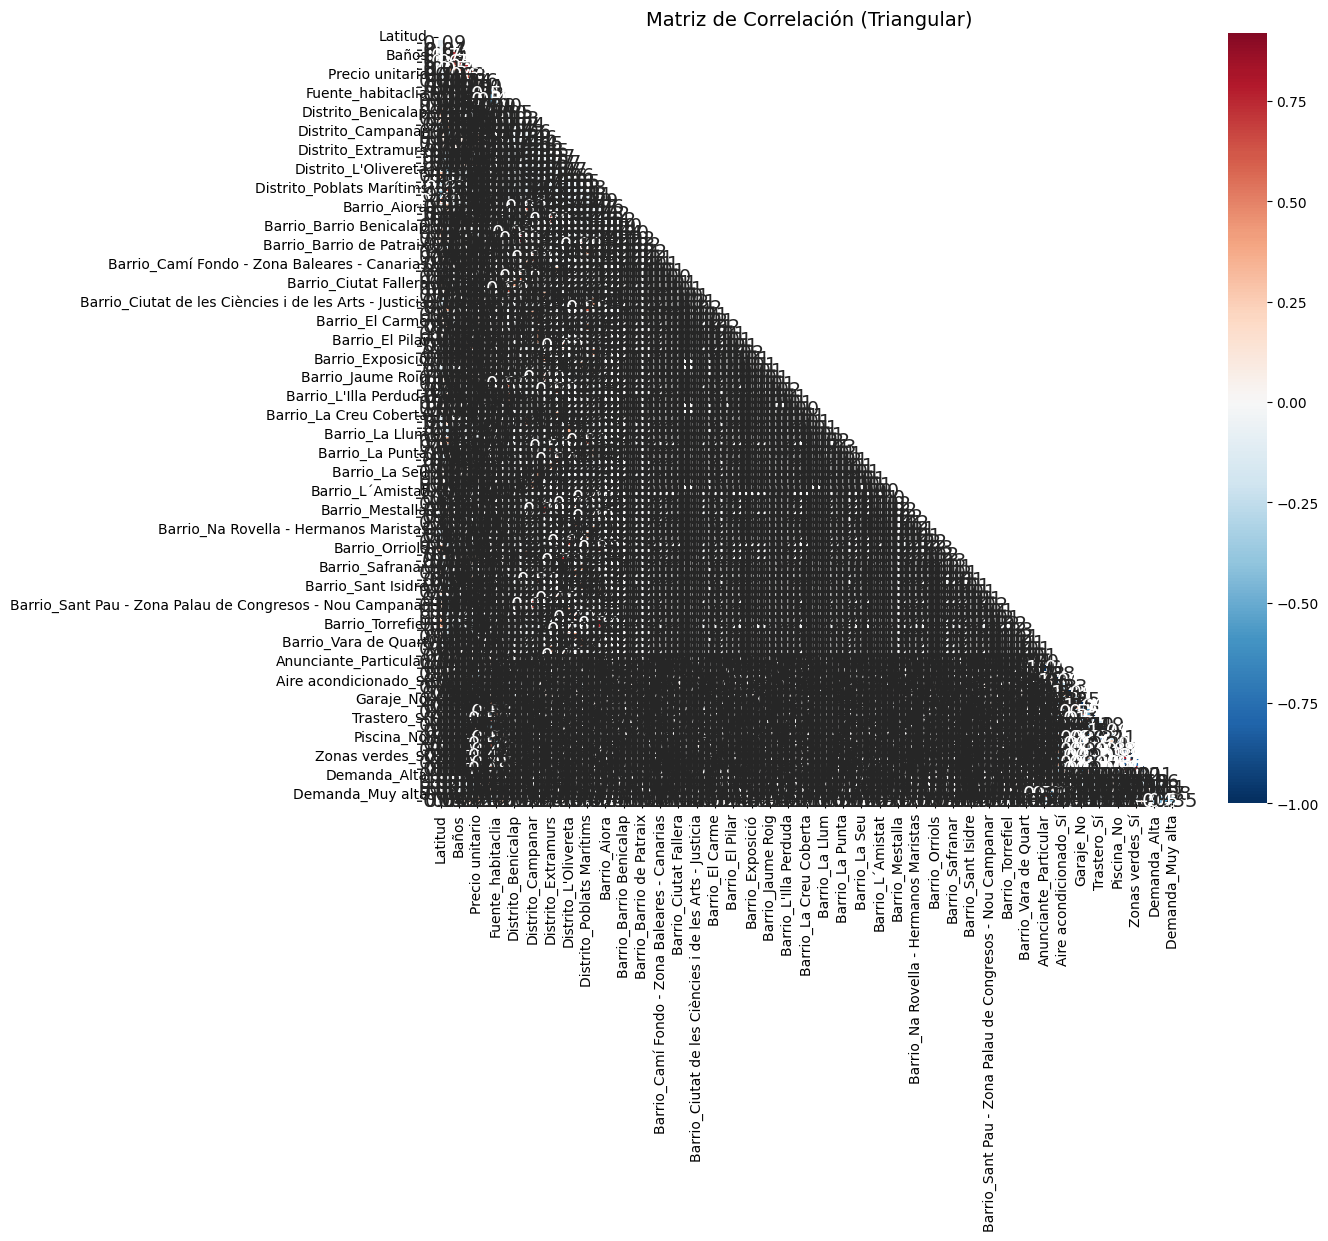

In [28]:
plt.figure(figsize=(12, 10))
# Solo variables numéricas
numeric_df = train_set.select_dtypes(include=[np.number])
corr = numeric_df.corr()

# Máscara para ver solo la mitad (evita duplicados)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title('Matriz de Correlación (Triangular)')
plt.show()

C:\Users\33778\AppData\Local\Temp\ipykernel_5888\1256273856.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Precio unitario', y='Distrito', data=train_set_bck, order=order, palette='magma')


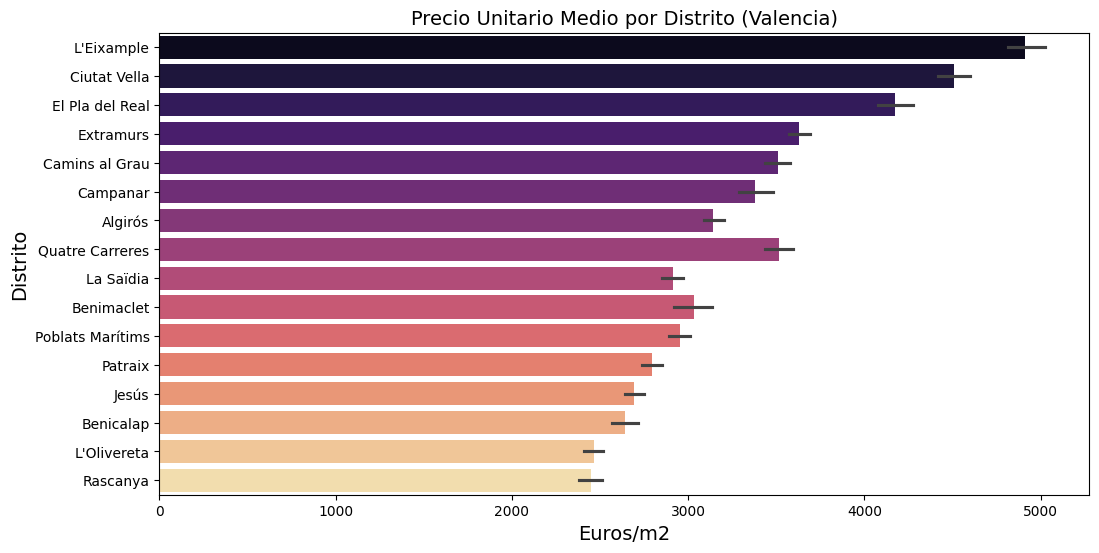

In [30]:
plt.figure(figsize=(12, 6))

# USAMOS train_set_bck que aún tiene la columna 'Distrito' original
order = train_set_bck.groupby('Distrito')['Precio unitario'].median().sort_values(ascending=False).index

sns.barplot(x='Precio unitario', y='Distrito', data=train_set_bck, order=order, palette='magma')

plt.title('Precio Unitario Medio por Distrito (Valencia)')
plt.xlabel('Euros/m2')
plt.show()

In [47]:
from sklearn.ensemble import RandomForestRegressor

# Configuramos el modelo directamente con valores óptimos
# n_estimators: número de árboles
# max_depth: profundidad para no memorizar datos (evita overfitting)
modelo_final = RandomForestRegressor(
    n_estimators=200, 
    max_depth=15, 
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Entrenamos el modelo
modelo_final.fit(X, y)

print("¡CONSEGUIDO! Modelo entrenado correctamente.")

¡CONSEGUIDO! Modelo entrenado correctamente.


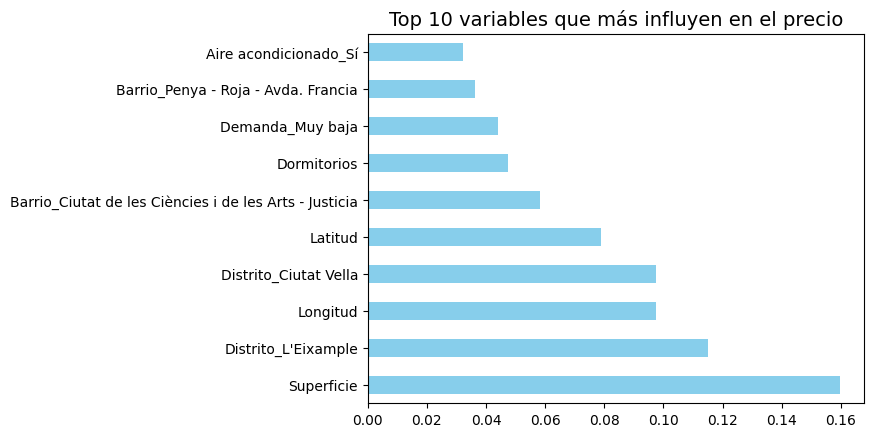

In [48]:
importancias = pd.Series(modelo_final.feature_importances_, index=X.columns)
importancias.sort_values(ascending=False).head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 variables que más influyen en el precio")
plt.show()

In [50]:
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Hacemos las predicciones con los datos de test
y_pred = modelo_final.predict(X_test)

# 2. Calculamos el error medio (en euros/m2)
mae = mean_absolute_error(y_test, y_pred)

# 3. Calculamos la precisión (R-squared)
r2 = r2_score(y_test, y_pred)

print(f"--- RENDIMIENTO DEL MODELO ---")
print(f"Error Medio (MAE): {mae:.2f} euros/m2")
print(f"Precisión (R2): {r2:.4f} (donde 1.0 es perfecto)")

--- RENDIMIENTO DEL MODELO ---
Error Medio (MAE): 525.26 euros/m2
Precisión (R2): 0.6626 (donde 1.0 es perfecto)


In [51]:
import pickle

# Guardamos el modelo en un archivo
with open('modelo_viviendas_valencia.pkl', 'wb') as f:
    pickle.dump(modelo_final, f)

print("Modelo guardado como 'modelo_viviendas_valencia.pkl'")

Modelo guardado como 'modelo_viviendas_valencia.pkl'


## Resumen Ejecutivo del Proyecto"Tras el análisis y modelado de los datos inmobiliarios de Valencia, hemos desarrollado un sistema de valoración basado en el algoritmo Random Forest que explica el 66% de la variabilidad de los precios del mercado ($R^2 = 0.66$).El modelo presenta un Error Medio Absoluto (MAE) de 525€/m². Esto indica que, aunque el sistema identifica con precisión las tendencias generales y la jerarquía de precios por barrios, existe una variabilidad intrínseca ligada al estado de conservación y calidades específicas que no están capturadas en los datos brutos.Las principales deducciones del estudio son:La ubicación es el factor soberano: Las coordenadas geográficas y el distrito tienen un peso mayor que las características físicas de la vivienda.Variables Críticas: El ascensor y la superficie actúan como los principales validadores del precio; su ausencia en determinadas zonas penaliza el valor de forma drástica, independientemente de otros extras.Potencial de Mejora: Para reducir el error actual, la futura línea de trabajo debería centrarse en la 'Ingeniería de Características', calculando distancias a puntos de interés (metro, playa, centro) y segmentando las propiedades por estado de reforma."¿Cómo presentar los gráficos?Para tu defensa, te recomiendo mostrar estos tres apoyos visuales:Gráfico de Importancia de Variables: Para mostrar que el modelo es "lógico" (que prioriza la superficie y la zona).Gráfico de Dispersión (Real vs Predicho): Para mostrar que los puntos siguen la línea diagonal (aunque con cierta dispersión por ese MAE de 525€).Mapa de Calor del EDA: Para recordar al público que el precio en Valencia es radial y depende totalmente de la ubicación.

In [53]:
# Al entrenar
modelo_final.fit(X, np.log1p(y))

# Al predecir (hay que revertir el logaritmo)
predicciones_reales = np.expm1(modelo_final.predict(X_test))

In [54]:
import numpy as np

# 1. Coordenadas de la Plaza del Ayuntamiento (Valencia)
centro_lat, centro_lon = 39.4700, -0.3763

# 2. Función para calcular la distancia (Haversine formula)
def calcular_distancia(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en km
    R = 6371.0
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

# 3. Creamos la nueva columna en el backup para que no de errores de "dummies"
train_set_bck['distancia_centro'] = calcular_distancia(
    train_set_bck['Latitud'], train_set_bck['Longitud'], 
    centro_lat, centro_lon
)

print("Nueva columna 'distancia_centro' creada con éxito.")
print(train_set_bck[['Barrio', 'distancia_centro']].head())

Nueva columna 'distancia_centro' creada con éxito.
              Barrio  distancia_centro
953     Tres Forques          2.315399
917     Tres Forques          2.348289
10938        El Grau          5.975690
7256   Sant Francesc          0.247889
7266   Sant Francesc          0.233467


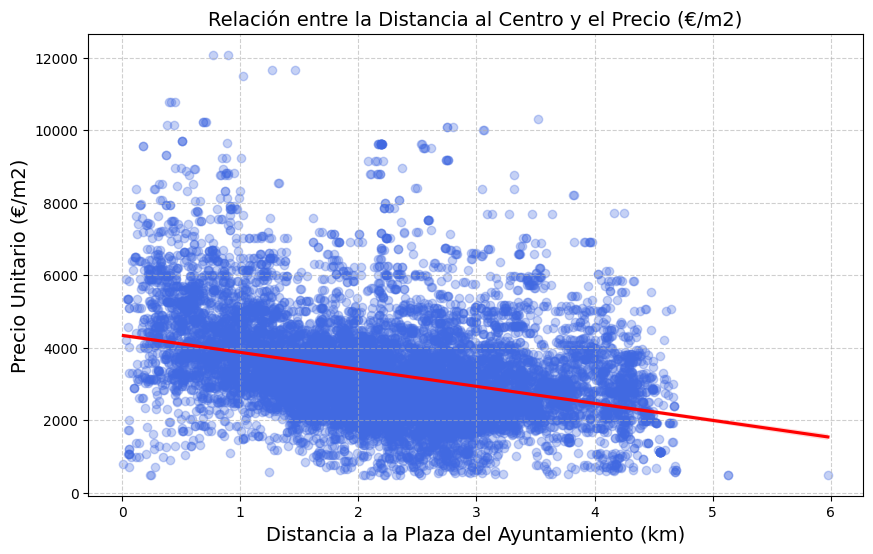

In [55]:
import seaborn as sns

# Configuramos el estilo
plt.figure(figsize=(10, 6))

# Creamos un gráfico de dispersión con una línea de tendencia (regresión)
sns.regplot(x='distancia_centro', y='Precio unitario', data=train_set_bck, 
            scatter_kws={'alpha':0.3, 'color':'royalblue'}, 
            line_kws={'color':'red'})

plt.title('Relación entre la Distancia al Centro y el Precio (€/m2)')
plt.xlabel('Distancia a la Plaza del Ayuntamiento (km)')
plt.ylabel('Precio Unitario (€/m2)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()